In [1]:
import numpy as np
import pandas as pd
import torch
import utils.datatuner as dt
import utils.tensorloader as dl
import utils.eval_metrics as metrics
import utils.modelhandler as mh
import warnings
import matplotlib.pyplot as plt
import sys
import os
from utils.config_util import read_config, parse_basic
from IPython.display import display
import ipywidgets as widgets

In [2]:
def plot_snapshots(target, pred, y_pred_upper, y_pred_lower, hour, OUTPATH, limit, actual_hours=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(target, '.-k', label="Truth")  # true values
    ax.plot(pred, 'b', label='Predicted')
    # insert actual time
    if(actual_hours.dt.hour.any()):
        ax.set_title(actual_hours.iloc[0].strftime("%a, %Y-%m-%d"), fontsize=20)
    else:
        ax.set_title('Forecast along horizon', fontsize=22)
    ax.fill_between(np.arange(pred.shape[0]), pred.squeeze(), y_pred_upper.squeeze(), alpha=0.1, color='g')
    ax.fill_between(np.arange(pred.shape[0]), y_pred_lower.squeeze(), pred.squeeze(), alpha=0.1, color='g')

    ax.set_xlabel("Hour", fontsize=18)
    ax.set_ylabel("Scaled Residual Load (-1,1)", fontsize=20)
    ax.legend(fontsize=20)
    ax.grid(b=True, linestyle='-')
    if(limit):
        plt.axhline(linewidth=2, color='r', y=limit)
    ax.grid()
    positions = range(0, len(pred), 2)
    labels = actual_hours.dt.hour.to_numpy()
    new_labels = labels[positions]
    plt.xticks(positions, new_labels)
    ax.set_xlabel("Hour of Day", fontsize=20)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.savefig(OUTPATH + 'eval_hour{}'.format(hour))
    plt.show(fig)

# Using ProLoaF for hourly predictions of the German power consumption of the open power system data platform

## 1) Data Selection, Preprocessing, and Configuration of Forecasting Model

First, we need to make sure that we either use local or external data (preferably in csv or xlsx format). We make ProLoaF aware of the data-path and some details that need to be taken care of during pandas dataframe reading through or preprocessing config. For more infos on the confid checkout the [CONFIGURATION.md](http://slash.acs-lab.eonerc.rwth-aachen.de:8083/notebooks/ggu/proloaf/notebooks/Configuration%20Helper.ipynb)

> **NOTE:** If you start with your forecasting task already with all features integrated in one csv file, you can skip the whole preprocessing step.

We now use fc_prep.py to do the job of importing, interpolation, aligning the timesteps, taking the minimum joint period of input data, and generating one hot encoding and cyclical encoding of calendric data, that is based on the timestamp.
More infos on the interpolation techniques is explained in [this notebook](http://slash.acs-lab.eonerc.rwth-aachen.de:8083/notebooks/mko/proloaf/notebooks/fc_train%20Explainer.ipynb).

In [3]:
!python3 ../source/fc_prep.py -s opsd_24

Importing CSV Data...
Importing time_series/2020-10-06/time_series_60min_singleindex.csv ...
...Importing finished. 
Importing weather_data/2020-09-16/weather_data.csv ...
...Importing finished. 
Some values are NaN. They are being filled...
...interpolation finished! No missing data left.
                     AT_load_actual_entsoe_transparency  DE_load_actual_entsoe_transparency
Time                                                                                       
2014-12-31 23:00:00                                 NaN                                 NaN
2015-01-01 00:00:00                              5946.0                             41151.0
2015-01-01 01:00:00                              5726.0                             40135.0
2015-01-01 02:00:00                              5347.0                             39106.0
2015-01-01 03:00:00                              5249.0                             38765.0
...                                                 ...          

## 2) Training

We do not call fc_train.py here in this notebook as we prefer to use it interactively via shell command. Calling it is as simple as: 

```python3 ../source/fc_prep.py -s opsd_24```

which will generate a trained RNN model that is stored in the path 'oracles'.
A step-by-step guide to what is done in fc_train follows in [this notebook](http://slash.acs-lab.eonerc.rwth-aachen.de:8083/notebooks/mko/proloaf/notebooks/fc_train%20Explainer.ipynb).

### 3) ProLoaF Performance Check
We now want to give a deeper look into the 24h-forecast the RNN is able to generate.

### Read in config file and set active paths 
Assuming opsd_24 exists in 'targets' and the model has been trained already, so it is stored in 'oracles' (see step 2))

In [4]:
config_path = 'opsd_24'
PAR = read_config(config_path, main_path="../")
torch.manual_seed(1)
model_name = PAR["model_name"]
data_path = PAR["data_path"]
INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])
DEVICE = "cpu"

target_id = PAR["target_id"]
SPLIT_RATIO = PAR["validation_split"]
HISTORY_HORIZON = PAR["history_horizon"]
FORECAST_HORIZON = PAR["forecast_horizon"]
feature_groups = PAR["feature_groups"]

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

### Load Data, Interpolate any missing values, and Split to use Test-Set only

In [5]:
# Read load data
df = pd.read_csv(INFILE, sep=";")
df = dt.fill_if_missing(df)

No missing data 



In [6]:
#Originally we have trained the model to predict 24h ahead.
adj_forecast_horizon = widgets.IntSlider(value=PAR["forecast_horizon"])
display(adj_forecast_horizon)

IntSlider(value=24)

In [7]:
FORECAST_HORIZON = adj_forecast_horizon.value

### Re-load Trained RNN and Generate Tensor using ProLoaF Dataloader

In [8]:
with torch.no_grad():
    net = torch.load(os.path.join("../",PAR["output_path"], model_name), map_location=torch.device(DEVICE))  # mapping to CPU
    
    df_new, _ = dt.scale_all(df, scalers=net.scalers, **PAR)
    df_new.index = df['Time']

    split_index = int(len(df_new.index) * SPLIT_RATIO)
    train_df = df_new.iloc[0:split_index]
    test_df = df_new.iloc[split_index:]
    
    test_data_loader = dl.make_dataloader(
        test_df,
        target_id,
        PAR["encoder_features"],
        PAR["decoder_features"],
        history_horizon=HISTORY_HORIZON,
        forecast_horizon=FORECAST_HORIZON, 
        shuffle=False,
    ).to(DEVICE)

In [9]:
print("Number of Test Samples: ", test_data_loader.dataset.inputs2.shape[0])
print("Forecast Horizon: ", test_data_loader.dataset.inputs2.shape[1])
print("Number of Features: ", test_data_loader.dataset.inputs2.shape[2])

Number of Test Samples:  8595
Forecast Horizon:  24
Number of Features:  43


Imagine the 3D-tensor to have these dimensions as mentioned above

<font size="1"> *Note:* The original author of this image is shaistha fathima in following blog post on [Medium](https://medium.com/secure-and-private-ai-writing-challenge/introduction-to-tensors-1-de7dded35fea)</font> 
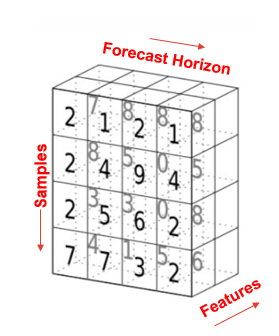

### Fetch Predictions

In [10]:
# fetch forecast horizon from the shape of the targets (check)
horizon = test_data_loader.dataset.targets.shape[1]
number_of_targets = test_data_loader.dataset.targets.shape[2]

record_targets, record_output = mh.get_prediction(net, test_data_loader, 
                                                  horizon, number_of_targets)

net.eval()

EncoderDecoder(
  (encoder): Encoder(
    (core): LSTM(5, 48, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (core): LSTM(43, 48, batch_first=True, dropout=0.3)
    (fc1): Linear(in_features=48, out_features=48, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc2): ModuleList(
      (0): Linear(in_features=48, out_features=1, bias=True)
      (1): Linear(in_features=48, out_features=1, bias=True)
    )
  )
)

### Fetch prediction upper bounds, lower bounds and mean expected values
This process is score dependent. We refer to the score with the term "criterion". Per default, ProLoaF trains with GNLL (=Negative Log-Likelihood under the assumption of a Standard-Normal Distribution)

In [11]:
criterion = net.criterion
print(criterion)

<function nll_gauss at 0x7fcd214ca430>


In [12]:
y_pred_upper, y_pred_lower, record_expected_values = mh.get_pred_interval(
    record_output, criterion, record_targets)

# rescale(test_output, test_targets)

### Let's Calculate the Deterministic and Probabilistic Forecast Metrics on the Test Set

In [13]:
# collect metrics per forecast step
mse_horizon = metrics.mse(record_targets, [record_expected_values], total=False)
rmse_horizon = metrics.rmse(record_targets, [record_expected_values], total=False)
sharpness_horizon = metrics.sharpness(None, [y_pred_upper, y_pred_lower], total=False)
coverage_horizon = metrics.picp(record_targets, [y_pred_upper, y_pred_lower], total=False)
mis_horizon = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05, total=False)

# collect metrics by disregarding the development over the forecast horizon
mse = metrics.mse(record_targets, [record_expected_values])
rmse = metrics.rmse(record_targets, [record_expected_values])
mase = metrics.mase(record_targets, [record_expected_values], 7*24)
rae = metrics.rae(record_targets, [record_expected_values])
mae = metrics.mae(record_targets, [record_expected_values])
qs = metrics.pinball_loss(record_targets, [y_pred_upper, y_pred_lower], [0.025, 0.975])
sharpness = metrics.sharpness(None, [y_pred_upper, y_pred_lower])
coverage = metrics.picp(record_targets, [y_pred_upper, y_pred_lower])
mis = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05)

### Choose time steps of interest and plot those

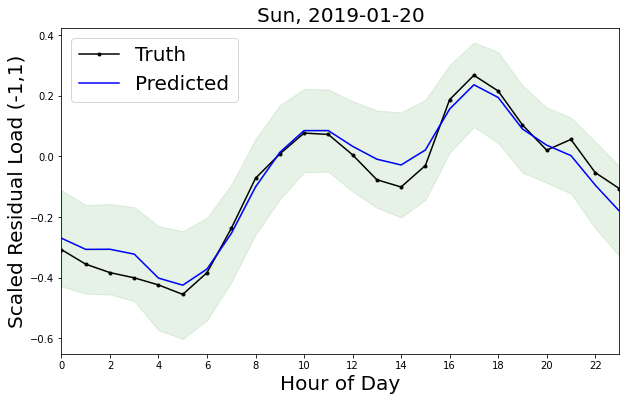

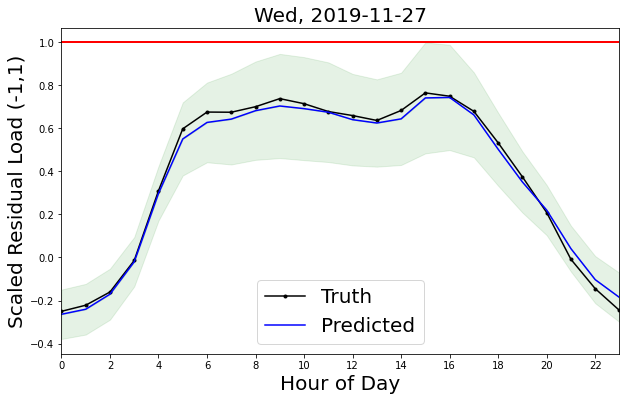

In [14]:
testhours = [314]
#h=314 is a Sunday


# Fetch the actual time from the datetimeindex in the pandas dataframe
actual_time = pd.to_datetime(df.loc[HISTORY_HORIZON+split_index:, "Time"])
for i in testhours:
    hours = actual_time.iloc[i : i + FORECAST_HORIZON]
    plot_snapshots(
        record_targets[i].detach().numpy(),
        record_expected_values[i].detach().numpy(),
        y_pred_upper[i].detach().numpy(),
        y_pred_lower[i].detach().numpy(),
        i,
        OUTDIR,
        None,
        hours,
    )

# Plot for days with possible congestion
testhours = [-840]
#h=386 is a Wednesday

# Fetch the actual time from the datetimeindex in the pandas dataframe
actual_time = pd.to_datetime(df.loc[HISTORY_HORIZON+split_index:, "Time"])
for i in testhours:
    hours = actual_time.iloc[i : i + FORECAST_HORIZON]
    plot_snapshots(
        record_targets[i].detach().numpy(),
        record_expected_values[i].detach().numpy(),
        y_pred_upper[i].detach().numpy(),
        y_pred_lower[i].detach().numpy(),
        i,
        OUTDIR,
        PAR["cap_limit"],
        hours,
    )

### How does the forecast model perform on average?

In [15]:
with torch.no_grad():
    print(
        metrics.results_table(
            model_name,
            mse.detach().numpy(),
            rmse.detach().numpy(),
            mase.detach().numpy(),
            rae.detach().numpy(),
            mae.detach().numpy(),
            sharpness.detach().numpy(),
            coverage.detach().numpy(),
            mis.detach().numpy(),
            qs.cpu().numpy(), 
            save_to_disc=OUTDIR,
        )
    )

                        MSE      RMSE      MASE       RAE       MAE  \
opsd_24_LSTM_gnll  0.007452  0.086326  0.520696  0.144745  0.054052   

                   Mean sharpness  Mean PICP   Mean IS  Quantile Score  
opsd_24_LSTM_gnll        0.348936   97.92321  0.459764        0.342983  


### Does the prediction perform equally good or bad over the whole test set?
We have fetched the predictions over the chosen forecast horizon for every hour in the test set. Let us visualize how this is done: 

[Image]()

A boxlot will serve as the most practical plot to show how much the error metrics deviate from one forecast situation to another. We refer to each forecast situation as one sample.

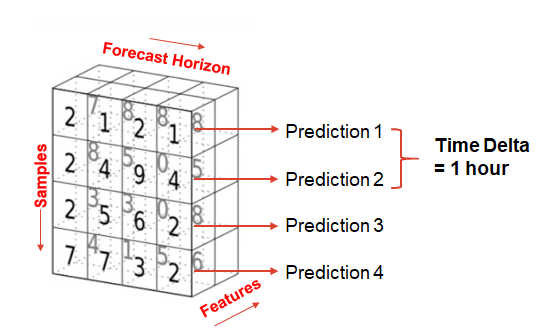

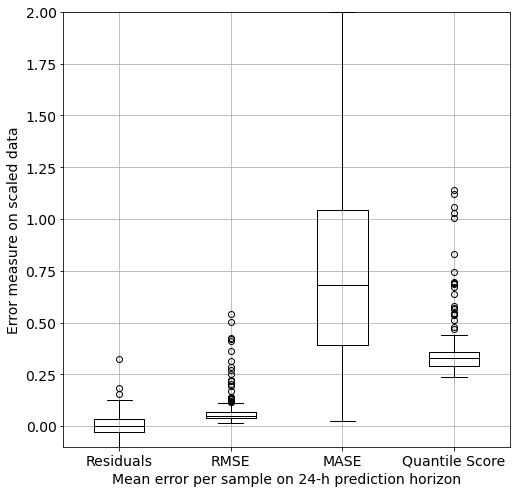

In [21]:
# To generate BOXPLOTS, lets fetch the per-sample-performances
with torch.no_grad():
    mse_per_sample = [metrics.mse(record_targets[i], [record_expected_values[i]]) for i, value in
                      enumerate(record_targets)]
    rmse_per_sample = [metrics.rmse(record_targets[i], [record_expected_values[i]]) for i, value in
                      enumerate(record_targets)]
    sharpness_per_sample = [metrics.sharpness(None, [y_pred_upper[i],y_pred_lower[i]]) for i, value in
                      enumerate(record_targets)]
    coverage_per_sample = [metrics.picp(record_targets[i], [y_pred_upper[i],y_pred_lower[i]]) for i, value in
                      enumerate(record_targets)]
    rae_per_sample = [metrics.rae(record_targets[i], [record_expected_values[i]]) for i, value in
                      enumerate(record_targets)]
    mae_per_sample = [metrics.mae(record_targets[i], [record_expected_values[i]]) for i, value in
                      enumerate(record_targets)]
    mis_per_sample = [metrics.mis(record_targets[i], [y_pred_upper[i], y_pred_lower[i]], alpha=0.05) for i, value in
                      enumerate(record_targets)]
    mase_per_sample = [metrics.mase(record_targets[i], [record_expected_values[i]], 0,
                                    insample_target=record_targets.roll(7*24,0)[i]) for i, value in
                      enumerate(record_targets)]

    residuals_per_sample = [metrics.residuals(record_targets[i],
                                        [record_expected_values[i]]) for i, value in enumerate(record_targets)]
    quantile_score_per_sample = [metrics.pinball_loss(record_targets[i], [y_pred_upper[i], y_pred_lower[i]], [0.025,0.975])
                              for i, value in enumerate(record_targets)]

    metrics_per_sample = pd.DataFrame(mse_per_sample).astype('float')
    metrics_per_sample['MSE'] = pd.DataFrame(mse_per_sample).astype('float')
    metrics_per_sample['RMSE'] = pd.DataFrame(rmse_per_sample).astype('float')
    metrics_per_sample['Sharpness'] = pd.DataFrame(sharpness_per_sample).astype('float')
    metrics_per_sample['PICP'] = pd.DataFrame(coverage_per_sample).astype('float')
    metrics_per_sample['RAE'] = pd.DataFrame(rae_per_sample).astype('float')
    metrics_per_sample['MAE'] = pd.DataFrame(mae_per_sample).astype('float')
    metrics_per_sample['MASE'] = pd.DataFrame(mase_per_sample).astype('float')
    metrics_per_sample['MIS'] = pd.DataFrame(mis_per_sample).astype('float')
    metrics_per_sample['Quantile Score'] = pd.DataFrame(quantile_score_per_sample).astype('float')
    metrics_per_sample['Residuals'] = pd.DataFrame(residuals_per_sample).astype('float')

fig = plt.figure(figsize=(8, 8))
ax1 = metrics_per_sample.iloc[::24].boxplot(column=['Residuals', 'RMSE', 'MASE', 'Quantile Score'],
                                            color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                                            figsize=(8.5, 10), fontsize=14)
ax1.set_xlabel('Mean error per sample on %i-h prediction horizon' % FORECAST_HORIZON , fontsize=14)
ax1.set_ylabel('Error measure on scaled data', fontsize=14)
ymin, ymax = -0.1, 2
ax1.set_ylim([ymin, ymax])
plt.show()

In [27]:
print("Remember that the number of test samples is", test_data_loader.dataset.inputs2.shape[0], ".")
print("The period ranges from",actual_time.iloc[0].strftime("%a, %Y-%m-%d"), "to", actual_time.iloc[-1].strftime("%a, %Y-%m-%d"), ".")
print("For sake of clarity we have plotted the samples in 24h intervals resulting in:", test_data_loader.dataset.inputs2.shape[0]/24, "days in the test set.")

Remember that the number of test samples is 8595 .
The period ranges from Sun, 2019-01-06 to Tue, 2019-12-31 .
For sake of clarity we have plotted the samples in 24h intervals resulting in: 358.125 days in the test set.


### How does the forecast perform on average over the forecast period (=24 hours)?

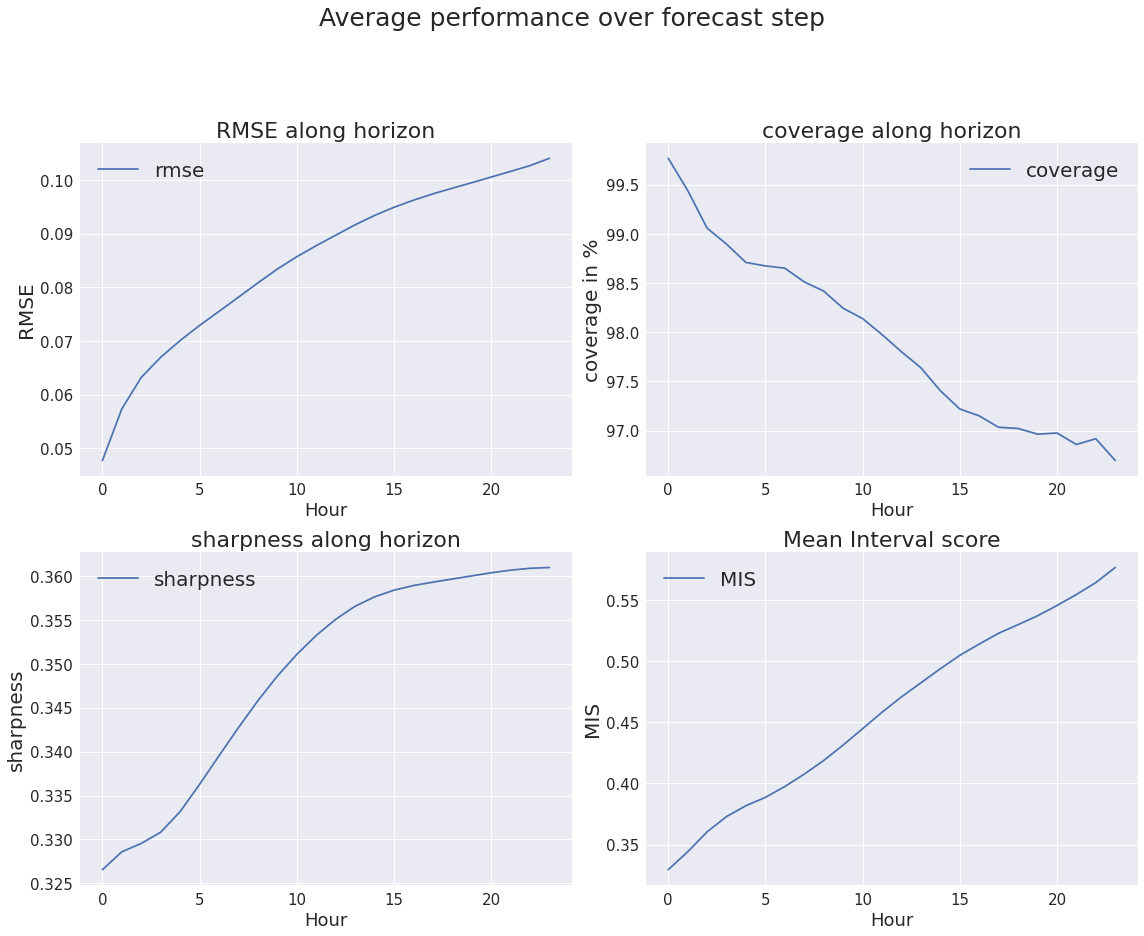

In [18]:
metrics.plot_metrics(
    rmse_horizon.detach().numpy(),
    sharpness_horizon.detach().numpy(),
    coverage_horizon.detach().numpy(),
    mis_horizon.detach().numpy(),
    OUTDIR,
    "Average performance over forecast step")